# Can Satellite Imagery Detect Metadata Errors?

## Cross-Validating Environmental Annotations with Google Earth Embeddings

**Research Question:** Do environmental samples with similar satellite imagery have similar ENVO (Environmental Ontology) annotations?

If yes → ENVO terms accurately capture physical reality
If no → Potential metadata quality issues

**The Experiment:**
1. Compare 246 environmental samples using two independent measures:
   - **Google Earth embeddings** (objective: what the satellite sees)
   - **ENVO embeddings** (subjective: what curators annotated)
2. Calculate similarity for thousands of sample pairs
3. Find disagreements: High satellite similarity but low metadata similarity
4. Use satellite data to suggest metadata corrections

**Why This Matters:**
- Millions of biosamples lack quality environmental metadata
- Manual curation is expensive and error-prone
- Satellite imagery provides objective, always-available environmental context
- Can we automate metadata quality control?

## 1. Data: Two Independent Views of Environmental Context

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import ast
import random
from itertools import combinations
from scipy.stats import pearsonr, spearmanr

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12

In [3]:
# Load the data with embeddings
df = pd.read_csv('../data/satisfying_biosamples_normalized_with_google_embeddings_with_envo_embeddings.csv', low_memory=False)

print(f"Total rows loaded: {len(df)}")
print(f"Columns: {list(df.columns)}")

# Check for the embedding columns
print("\n=== EMBEDDING DATA QUALITY ===")
print(f"Rows with google_earth_embeddings: {df['google_earth_embeddings'].notna().sum()}")
print(f"Rows with envo_broad_scale_embedding: {df['envo_broad_scale_embedding'].notna().sum()}")
print(f"Rows with envo_local_scale_embedding: {df['envo_local_scale_embedding'].notna().sum()}")
print(f"Rows with envo_medium_embedding: {df['envo_medium_embedding'].notna().sum()}")

# Filter for rows with complete data
has_all_embeddings = (
    df['google_earth_embeddings'].notna() &
    df['envo_broad_scale_embedding'].notna() &
    df['envo_local_scale_embedding'].notna() &
    df['envo_medium_embedding'].notna()
)
df_both = df[has_all_embeddings].copy()

print(f"\nRows with ALL embeddings (GE + 3 ENVO): {len(df_both)}")
print(f"Success rate: {len(df_both)/len(df)*100:.1f}%")

Total rows loaded: 34128
Columns: ['accession', 'collection_date', 'env_broad_scale', 'env_local_scale', 'env_medium', 'collection_date_raw', 'lat_lon_raw', 'latitude', 'longitude', 'google_earth_embeddings', 'envo_broad_scale_embedding', 'envo_medium_embedding', 'envo_local_scale_embedding']

=== EMBEDDING DATA QUALITY ===
Rows with google_earth_embeddings: 34128
Rows with envo_broad_scale_embedding: 34128
Rows with envo_local_scale_embedding: 34128
Rows with envo_medium_embedding: 34128

Rows with ALL embeddings (GE + 3 ENVO): 34128
Success rate: 100.0%


## Embedding Processing Functions

In [4]:
def parse_embedding(embedding_str):
    """Parse embedding string to numpy array."""
    try:
        # Handle string representation of list
        if isinstance(embedding_str, str):
            embedding_list = ast.literal_eval(embedding_str)
        else:
            embedding_list = embedding_str
        return np.array(embedding_list, dtype=np.float32)
    except Exception as e:
        print(f"Error parsing embedding: {e}")
        return None

def compute_cosine_similarity(emb1, emb2):
    """Compute cosine similarity between two embeddings."""
    if emb1 is None or emb2 is None:
        return np.nan

    # Reshape for sklearn
    emb1 = emb1.reshape(1, -1)
    emb2 = emb2.reshape(1, -1)

    return cosine_similarity(emb1, emb2)[0, 0]

In [5]:
# Parse embeddings
print("Parsing Google Earth embeddings...")
df_both['ge_embedding'] = df_both['google_earth_embeddings'].apply(parse_embedding)

print("Parsing ENVO embeddings (3 types in MIxS order: broad, local, medium)...")
df_both['envo_broad_embedding'] = df_both['envo_broad_scale_embedding'].apply(parse_embedding)
df_both['envo_local_embedding'] = df_both['envo_local_scale_embedding'].apply(parse_embedding)
df_both['envo_medium_embedding'] = df_both['envo_medium_embedding'].apply(parse_embedding)

# Filter out any rows where parsing failed
valid_embeddings = (
    df_both['ge_embedding'].notna() &
    df_both['envo_broad_embedding'].notna() &
    df_both['envo_local_embedding'].notna() &
    df_both['envo_medium_embedding'].notna()
)
df_clean = df_both[valid_embeddings].copy()

print(f"\nRows with valid parsed embeddings: {len(df_clean)}")

# Check embedding dimensions
if len(df_clean) > 0:
    ge_dim = len(df_clean.iloc[0]['ge_embedding'])
    envo_broad_dim = len(df_clean.iloc[0]['envo_broad_embedding'])
    envo_local_dim = len(df_clean.iloc[0]['envo_local_embedding'])
    envo_medium_dim = len(df_clean.iloc[0]['envo_medium_embedding'])
    print(f"\nGoogle Earth embedding dimension: {ge_dim}")
    print(f"ENVO broad_scale embedding dimension: {envo_broad_dim}")
    print(f"ENVO local_scale embedding dimension: {envo_local_dim}")
    print(f"ENVO medium embedding dimension: {envo_medium_dim}")

Parsing Google Earth embeddings...
Parsing ENVO embeddings (3 types in MIxS order: broad, local, medium)...

Rows with valid parsed embeddings: 34128

Google Earth embedding dimension: 64
ENVO broad_scale embedding dimension: 1536
ENVO local_scale embedding dimension: 1536
ENVO medium embedding dimension: 1536


## 2. Method: Pairwise Similarity Analysis

**Approach:** For every pair of samples, compute:
- **GE Similarity:** Cosine similarity between their satellite embeddings
- **ENVO Similarity:** Cosine similarity between their ontology embeddings

**Why pairs?**
- Similarity is relative - we need to compare samples to each other
- If GE and ENVO agree, both high or both low similarity is good
- **Disagreement is the signal:** High GE + Low ENVO = metadata problem

**Scientific Rigor:**
- Generate 10,000 unique pairs (or all possible if < 10k)
- Remove "degenerate" pairs (similarity > 0.95) that inflate correlation
- Compare before/after filtering to test robustness

In [6]:
from itertools import combinations

# Calculate maximum possible unique pairs
n_samples = len(df_clean)
max_possible_pairs = n_samples * (n_samples - 1) // 2

print(f"Total samples: {n_samples}")
print(f"Maximum possible unique pairs: {max_possible_pairs:,}")

# Generate a large number of unique pairs (100,000 or all if less)
target_pairs = min(100000, max_possible_pairs)

print(f"\nGenerating {target_pairs:,} unique pairs...")

# Use combinations to ensure unique pairs (no duplicates, no self-pairs)
all_possible_pairs = list(combinations(range(n_samples), 2))

# Sample from all possible pairs if we want fewer than the maximum
if target_pairs < len(all_possible_pairs):
    # Set seed for reproducibility
    random.seed(42)
    pairs = random.sample(all_possible_pairs, target_pairs)
else:
    pairs = all_possible_pairs

print(f"Generated {len(pairs):,} unique pairs (no self-pairs, no duplicates by construction)")

Total samples: 34128
Maximum possible unique pairs: 582,343,128

Generating 100,000 unique pairs...
Generated 100,000 unique pairs (no self-pairs, no duplicates by construction)


In [7]:
# Calculate cosine similarities for all pairs
# We'll compare Google Earth vs each of the 3 ENVO embedding types (in MIxS order)
pair_info = []

print(f"Computing cosine similarities for {len(pairs):,} pairs...")

for i, (idx1, idx2) in enumerate(pairs):
    if (i + 1) % 1000 == 0:
        print(f"Processing pair {i+1:,}/{len(pairs):,}")

    row1 = df_clean.iloc[idx1]
    row2 = df_clean.iloc[idx2]

    # Calculate Google Earth similarity
    ge_sim = compute_cosine_similarity(row1['ge_embedding'], row2['ge_embedding'])

    # Calculate ENVO similarities for all 3 types (MIxS order: broad, local, medium)
    envo_broad_sim = compute_cosine_similarity(row1['envo_broad_embedding'], row2['envo_broad_embedding'])
    envo_local_sim = compute_cosine_similarity(row1['envo_local_embedding'], row2['envo_local_embedding'])
    envo_medium_sim = compute_cosine_similarity(row1['envo_medium_embedding'], row2['envo_medium_embedding'])

    # Only include pairs with valid similarities
    if not any(np.isnan([ge_sim, envo_broad_sim, envo_local_sim, envo_medium_sim])):
        pair_info.append({
            'accession_1': row1['accession'],
            'accession_2': row2['accession'],
            'ge_similarity': ge_sim,
            'envo_broad_similarity': envo_broad_sim,
            'envo_local_similarity': envo_local_sim,
            'envo_medium_similarity': envo_medium_sim
        })

# Create DataFrame with all pairs
pairs_df = pd.DataFrame(pair_info)

print(f"\nComputed similarities for {len(pairs_df):,} valid pairs")
print(f"Google Earth similarity range: [{pairs_df['ge_similarity'].min():.3f}, {pairs_df['ge_similarity'].max():.3f}]")
print(f"ENVO broad_scale similarity range: [{pairs_df['envo_broad_similarity'].min():.3f}, {pairs_df['envo_broad_similarity'].max():.3f}]")
print(f"ENVO local_scale similarity range: [{pairs_df['envo_local_similarity'].min():.3f}, {pairs_df['envo_local_similarity'].max():.3f}]")
print(f"ENVO medium similarity range: [{pairs_df['envo_medium_similarity'].min():.3f}, {pairs_df['envo_medium_similarity'].max():.3f}]")

Computing cosine similarities for 100,000 pairs...
Processing pair 1,000/100,000
Processing pair 2,000/100,000
Processing pair 3,000/100,000
Processing pair 4,000/100,000
Processing pair 5,000/100,000
Processing pair 6,000/100,000
Processing pair 7,000/100,000
Processing pair 8,000/100,000
Processing pair 9,000/100,000
Processing pair 10,000/100,000
Processing pair 11,000/100,000
Processing pair 12,000/100,000
Processing pair 13,000/100,000
Processing pair 14,000/100,000
Processing pair 15,000/100,000
Processing pair 16,000/100,000
Processing pair 17,000/100,000
Processing pair 18,000/100,000
Processing pair 19,000/100,000
Processing pair 20,000/100,000
Processing pair 21,000/100,000
Processing pair 22,000/100,000
Processing pair 23,000/100,000
Processing pair 24,000/100,000
Processing pair 25,000/100,000
Processing pair 26,000/100,000
Processing pair 27,000/100,000
Processing pair 28,000/100,000
Processing pair 29,000/100,000
Processing pair 30,000/100,000
Processing pair 31,000/100,0

## 3. Critical Test: Are Results Driven by Duplicate Samples?

**The Problem:**
If many pairs are near-identical (same location, same ENVO terms), they create artificial correlation.
- GE similarity = 1.0, ENVO similarity = 1.0 → Perfect agreement
- But this doesn't test our hypothesis - it's just measuring identity

**The Solution:**
Filter out "degenerate pairs" where either metric > 0.95

**What we'll learn:**
- If correlation **drops significantly** after filtering → Original result was inflated
- If correlation **stays strong** → Result is robust and meaningful

In [8]:
print("=== DEGENERATE PAIR FILTERING ===")
print(f"\nStarting with {len(pairs_df):,} pairs\n")

# Diagnostic: Count pairs with very high similarity on either axis
high_ge = (pairs_df['ge_similarity'] > 0.95).sum()
high_broad = (pairs_df['envo_broad_similarity'] > 0.95).sum()
high_local = (pairs_df['envo_local_similarity'] > 0.95).sum()
high_medium = (pairs_df['envo_medium_similarity'] > 0.95).sum()

print("Pairs with similarity > 0.95 (potentially degenerate):")
print(f"  Google Earth: {high_ge:,} pairs ({high_ge/len(pairs_df)*100:.1f}%)")
print(f"  ENVO broad_scale: {high_broad:,} pairs ({high_broad/len(pairs_df)*100:.1f}%)")
print(f"  ENVO local_scale: {high_local:,} pairs ({high_local/len(pairs_df)*100:.1f}%)")
print(f"  ENVO medium: {high_medium:,} pairs ({high_medium/len(pairs_df)*100:.1f}%)")

# Count perfect matches (both GE and ENVO = 1.0)
perfect_matches = ((pairs_df['ge_similarity'] == 1.0) &
                   (pairs_df['envo_broad_similarity'] == 1.0)).sum()
print(f"\nPerfect matches (GE=1.0 AND ENVO broad=1.0): {perfect_matches:,} pairs")

# Apply filtering: Remove degenerate pairs
# Degenerate = similarity > 0.95 on either GE or ANY ENVO metric
pairs_filtered = pairs_df[
    (pairs_df['ge_similarity'] <= 0.95) &
    (pairs_df['envo_broad_similarity'] <= 0.95) &
    (pairs_df['envo_local_similarity'] <= 0.95) &
    (pairs_df['envo_medium_similarity'] <= 0.95)
].copy()

removed_count = len(pairs_df) - len(pairs_filtered)
print(f"\nRemoved {removed_count:,} degenerate pairs (similarity > 0.95 on any metric)")
print(f"Remaining: {len(pairs_filtered):,} pairs ({len(pairs_filtered)/len(pairs_df)*100:.1f}% of original)")

# Extract similarity arrays for original dataset
ge_similarities_orig = pairs_df['ge_similarity'].values
envo_broad_similarities_orig = pairs_df['envo_broad_similarity'].values
envo_local_similarities_orig = pairs_df['envo_local_similarity'].values
envo_medium_similarities_orig = pairs_df['envo_medium_similarity'].values

# Extract similarity arrays for filtered dataset
ge_similarities = pairs_filtered['ge_similarity'].values
envo_broad_similarities = pairs_filtered['envo_broad_similarity'].values
envo_local_similarities = pairs_filtered['envo_local_similarity'].values
envo_medium_similarities = pairs_filtered['envo_medium_similarity'].values

print(f"\n=== CORRELATION ANALYSIS: BEFORE vs AFTER FILTERING ===")

# Original correlations (MIxS order: broad, local, medium)
pearson_broad_orig, _ = pearsonr(ge_similarities_orig, envo_broad_similarities_orig)
spearman_broad_orig, _ = spearmanr(ge_similarities_orig, envo_broad_similarities_orig)
pearson_local_orig, _ = pearsonr(ge_similarities_orig, envo_local_similarities_orig)
spearman_local_orig, _ = spearmanr(ge_similarities_orig, envo_local_similarities_orig)
pearson_medium_orig, _ = pearsonr(ge_similarities_orig, envo_medium_similarities_orig)
spearman_medium_orig, _ = spearmanr(ge_similarities_orig, envo_medium_similarities_orig)

# Filtered correlations (MIxS order: broad, local, medium)
pearson_broad, pearson_broad_p = pearsonr(ge_similarities, envo_broad_similarities)
spearman_broad, spearman_broad_p = spearmanr(ge_similarities, envo_broad_similarities)
pearson_local, pearson_local_p = pearsonr(ge_similarities, envo_local_similarities)
spearman_local, spearman_local_p = spearmanr(ge_similarities, envo_local_similarities)
pearson_medium, pearson_medium_p = pearsonr(ge_similarities, envo_medium_similarities)
spearman_medium, spearman_medium_p = spearmanr(ge_similarities, envo_medium_similarities)

print("\n1. Google Earth vs ENVO broad_scale:")
print(f"  BEFORE filtering:")
print(f"    Pearson:  {pearson_broad_orig:.3f}")
print(f"    Spearman: {spearman_broad_orig:.3f}")
print(f"  AFTER filtering:")
print(f"    Pearson:  {pearson_broad:.3f} (Δ = {pearson_broad - pearson_broad_orig:+.3f}) p={pearson_broad_p:.2e}")
print(f"    Spearman: {spearman_broad:.3f} (Δ = {spearman_broad - spearman_broad_orig:+.3f}) p={spearman_broad_p:.2e}")

print("\n2. Google Earth vs ENVO local_scale:")
print(f"  BEFORE filtering:")
print(f"    Pearson:  {pearson_local_orig:.3f}")
print(f"    Spearman: {spearman_local_orig:.3f}")
print(f"  AFTER filtering:")
print(f"    Pearson:  {pearson_local:.3f} (Δ = {pearson_local - pearson_local_orig:+.3f}) p={pearson_local_p:.2e}")
print(f"    Spearman: {spearman_local:.3f} (Δ = {spearman_local - spearman_local_orig:+.3f}) p={spearman_local_p:.2e}")

print("\n3. Google Earth vs ENVO medium:")
print(f"  BEFORE filtering:")
print(f"    Pearson:  {pearson_medium_orig:.3f}")
print(f"    Spearman: {spearman_medium_orig:.3f}")
print(f"  AFTER filtering:")
print(f"    Pearson:  {pearson_medium:.3f} (Δ = {pearson_medium - pearson_medium_orig:+.3f}) p={pearson_medium_p:.2e}")
print(f"    Spearman: {spearman_medium:.3f} (Δ = {spearman_medium - spearman_medium_orig:+.3f}) p={spearman_medium_p:.2e}")

print("\n=== INTERPRETATION ===")
if abs(pearson_broad - pearson_broad_orig) > 0.1:
    print("⚠️  Large change in correlation after filtering (Δ > 0.1)")
    print("    Original correlation was likely inflated by degenerate pairs")
else:
    print("✅ Correlation remained stable after filtering (Δ < 0.1)")
    print("    Relationship is robust to removal of degenerate pairs")

# Summary statistics for filtered data (MIxS order)
print("\n=== SUMMARY STATISTICS (FILTERED DATA) ===")
print("Google Earth Embeddings:")
print(f"  Mean: {np.mean(ge_similarities):.3f}")
print(f"  Std: {np.std(ge_similarities):.3f}")
print(f"  Median: {np.median(ge_similarities):.3f}")

print("\nENVO broad_scale:")
print(f"  Mean: {np.mean(envo_broad_similarities):.3f}")
print(f"  Std: {np.std(envo_broad_similarities):.3f}")
print(f"  Median: {np.median(envo_broad_similarities):.3f}")

print("\nENVO local_scale:")
print(f"  Mean: {np.mean(envo_local_similarities):.3f}")
print(f"  Std: {np.std(envo_local_similarities):.3f}")
print(f"  Median: {np.median(envo_local_similarities):.3f}")

print("\nENVO medium:")
print(f"  Mean: {np.mean(envo_medium_similarities):.3f}")
print(f"  Std: {np.std(envo_medium_similarities):.3f}")
print(f"  Median: {np.median(envo_medium_similarities):.3f}")

=== DEGENERATE PAIR FILTERING ===

Starting with 100,000 pairs

Pairs with similarity > 0.95 (potentially degenerate):
  Google Earth: 185 pairs (0.2%)
  ENVO broad_scale: 1,847 pairs (1.8%)
  ENVO local_scale: 1,195 pairs (1.2%)
  ENVO medium: 5,122 pairs (5.1%)

Perfect matches (GE=1.0 AND ENVO broad=1.0): 36 pairs

Removed 7,198 degenerate pairs (similarity > 0.95 on any metric)
Remaining: 92,802 pairs (92.8% of original)

=== CORRELATION ANALYSIS: BEFORE vs AFTER FILTERING ===

1. Google Earth vs ENVO broad_scale:
  BEFORE filtering:
    Pearson:  0.069
    Spearman: 0.024
  AFTER filtering:
    Pearson:  0.024 (Δ = -0.045) p=4.89e-13
    Spearman: 0.011 (Δ = -0.014) p=1.09e-03

2. Google Earth vs ENVO local_scale:
  BEFORE filtering:
    Pearson:  0.145
    Spearman: 0.071
  AFTER filtering:
    Pearson:  0.092 (Δ = -0.054) p=5.44e-172
    Spearman: 0.055 (Δ = -0.016) p=4.28e-63

3. Google Earth vs ENVO medium:
  BEFORE filtering:
    Pearson:  0.080
    Spearman: 0.049
  AFTER fi

## 4. Which ENVO Scale Matters Most?

**The MIxS Standard defines 3 environmental scales (in order):**
- **Broad scale:** Biome level (e.g., "terrestrial biome", "marine biome")
- **Local scale:** Fine-grained (e.g., "agricultural field", "coastal zone")
- **Medium:** Intermediate (e.g., "soil", "sea water")

**Research Question:** Which scale correlates best with satellite imagery?

**Hypotheses:**
1. Broad scale might correlate best (satellite sees biome-level features)
2. Local scale might correlate best (satellite resolution is 10m)
3. **Combination might be best** (all three scales provide complementary information)

We test 5 approaches (MIxS order: broad, local, medium):
1. Broad scale alone
2. Local scale alone
3. Medium alone
4. **Combined (concatenated):** All 3 embeddings → 4608-dim vector
5. **Weighted average:** Mean of 3 embeddings → 1536-dim vector

In [9]:
print("=== COMBINED ENVO EMBEDDINGS ===")
print("\nTesting whether combining multiple ENVO scales improves correlation with Google Earth\n")

# For each pair, we'll compute similarities using combined ENVO embeddings
combined_similarities = []

print("Computing similarities with combined ENVO embeddings (MIxS order: broad, local, medium)...")

for idx, row in pairs_filtered.iterrows():
    # Get the original sample indices
    sample1 = df_clean[df_clean['accession'] == row['accession_1']].iloc[0]
    sample2 = df_clean[df_clean['accession'] == row['accession_2']].iloc[0]

    # Method 1: Concatenate all three ENVO embeddings in MIxS order
    envo_combined_1 = np.concatenate([
        sample1['envo_broad_embedding'],
        sample1['envo_local_embedding'],
        sample1['envo_medium_embedding']
    ])

    envo_combined_2 = np.concatenate([
        sample2['envo_broad_embedding'],
        sample2['envo_local_embedding'],
        sample2['envo_medium_embedding']
    ])

    # Compute similarity on concatenated embeddings
    combined_sim = compute_cosine_similarity(envo_combined_1, envo_combined_2)
    combined_similarities.append(combined_sim)

# Add to filtered pairs dataframe
pairs_filtered['envo_combined_similarity'] = combined_similarities
envo_combined_similarities = np.array(combined_similarities)

print(f"Combined ENVO embedding dimension: {len(envo_combined_1)} (1536×3)")
print(f"Combined similarity range: [{envo_combined_similarities.min():.3f}, {envo_combined_similarities.max():.3f}]")

# Compute correlation
pearson_combined, pearson_combined_p = pearsonr(ge_similarities, envo_combined_similarities)
spearman_combined, spearman_combined_p = spearmanr(ge_similarities, envo_combined_similarities)

print(f"\n4. Google Earth vs ENVO COMBINED (concatenated broad+local+medium):")
print(f"    Pearson:  {pearson_combined:.3f} (p={pearson_combined_p:.2e})")
print(f"    Spearman: {spearman_combined:.3f} (p={spearman_combined_p:.2e})")

# Compare to individual ENVO types (MIxS order)
print(f"\n=== COMPARISON: INDIVIDUAL vs COMBINED ===")
print(f"  ENVO broad_scale alone:  Pearson r = {pearson_broad:.3f}")
print(f"  ENVO local_scale alone:  Pearson r = {pearson_local:.3f}")
print(f"  ENVO medium alone:       Pearson r = {pearson_medium:.3f}")
print(f"  ENVO COMBINED (concat):  Pearson r = {pearson_combined:.3f}")

# Determine best approach
all_correlations = [
    ('broad_scale', pearson_broad),
    ('local_scale', pearson_local),
    ('medium', pearson_medium),
    ('COMBINED', pearson_combined)
]
best_approach = max(all_correlations, key=lambda x: abs(x[1]))

print(f"\n📊 BEST CORRELATION: {best_approach[0]} (r = {best_approach[1]:.3f})")

if best_approach[0] == 'COMBINED':
    improvement = pearson_combined - max([pearson_broad, pearson_local, pearson_medium])
    print(f"   Combining all three ENVO scales improves correlation by {improvement:+.3f}")
else:
    print(f"   Single ENVO scale ({best_approach[0]}) performs better than combination")

# Method 2: Try weighted average (optional exploration)
print(f"\n=== ALTERNATIVE: WEIGHTED AVERAGE ===")
print("Testing if averaging embeddings (instead of concatenation) works better...")

weighted_similarities = []
for idx, row in pairs_filtered.iterrows():
    sample1 = df_clean[df_clean['accession'] == row['accession_1']].iloc[0]
    sample2 = df_clean[df_clean['accession'] == row['accession_2']].iloc[0]

    # Average the three ENVO embeddings (equal weight, MIxS order)
    envo_avg_1 = (sample1['envo_broad_embedding'] +
                  sample1['envo_local_embedding'] +
                  sample1['envo_medium_embedding']) / 3

    envo_avg_2 = (sample2['envo_broad_embedding'] +
                  sample2['envo_local_embedding'] +
                  sample2['envo_medium_embedding']) / 3

    weighted_sim = compute_cosine_similarity(envo_avg_1, envo_avg_2)
    weighted_similarities.append(weighted_sim)

pairs_filtered['envo_weighted_similarity'] = weighted_similarities
envo_weighted_similarities = np.array(weighted_similarities)

pearson_weighted, pearson_weighted_p = pearsonr(ge_similarities, envo_weighted_similarities)
spearman_weighted, spearman_weighted_p = spearmanr(ge_similarities, envo_weighted_similarities)

print(f"\n5. Google Earth vs ENVO WEIGHTED AVERAGE:")
print(f"    Pearson:  {pearson_weighted:.3f} (p={pearson_weighted_p:.2e})")
print(f"    Spearman: {spearman_weighted:.3f} (p={spearman_weighted_p:.2e})")

# Final comparison including weighted (MIxS order)
all_methods = [
    ('broad_scale alone', pearson_broad),
    ('local_scale alone', pearson_local),
    ('medium alone', pearson_medium),
    ('COMBINED (concatenated)', pearson_combined),
    ('WEIGHTED AVERAGE', pearson_weighted)
]
best_overall = max(all_methods, key=lambda x: abs(x[1]))

print(f"\n=== FINAL RANKING ===")
sorted_methods = sorted(all_methods, key=lambda x: abs(x[1]), reverse=True)
for rank, (method, r) in enumerate(sorted_methods, 1):
    marker = "👑" if rank == 1 else f" {rank}."
    print(f"{marker} {method:25s} r = {r:.3f}")

=== COMBINED ENVO EMBEDDINGS ===

Testing whether combining multiple ENVO scales improves correlation with Google Earth

Computing similarities with combined ENVO embeddings (MIxS order: broad, local, medium)...
Combined ENVO embedding dimension: 4608 (1536×3)
Combined similarity range: [0.067, 0.749]

4. Google Earth vs ENVO COMBINED (concatenated broad+local+medium):
    Pearson:  0.075 (p=1.05e-115)
    Spearman: 0.039 (p=4.29e-33)

=== COMPARISON: INDIVIDUAL vs COMBINED ===
  ENVO broad_scale alone:  Pearson r = 0.024
  ENVO local_scale alone:  Pearson r = 0.092
  ENVO medium alone:       Pearson r = 0.048
  ENVO COMBINED (concat):  Pearson r = 0.075

📊 BEST CORRELATION: local_scale (r = 0.092)
   Single ENVO scale (local_scale) performs better than combination

=== ALTERNATIVE: WEIGHTED AVERAGE ===
Testing if averaging embeddings (instead of concatenation) works better...

5. Google Earth vs ENVO WEIGHTED AVERAGE:
    Pearson:  0.091 (p=4.49e-171)
    Spearman: 0.059 (p=1.32e-72)


## Visualization (Filtered Data)

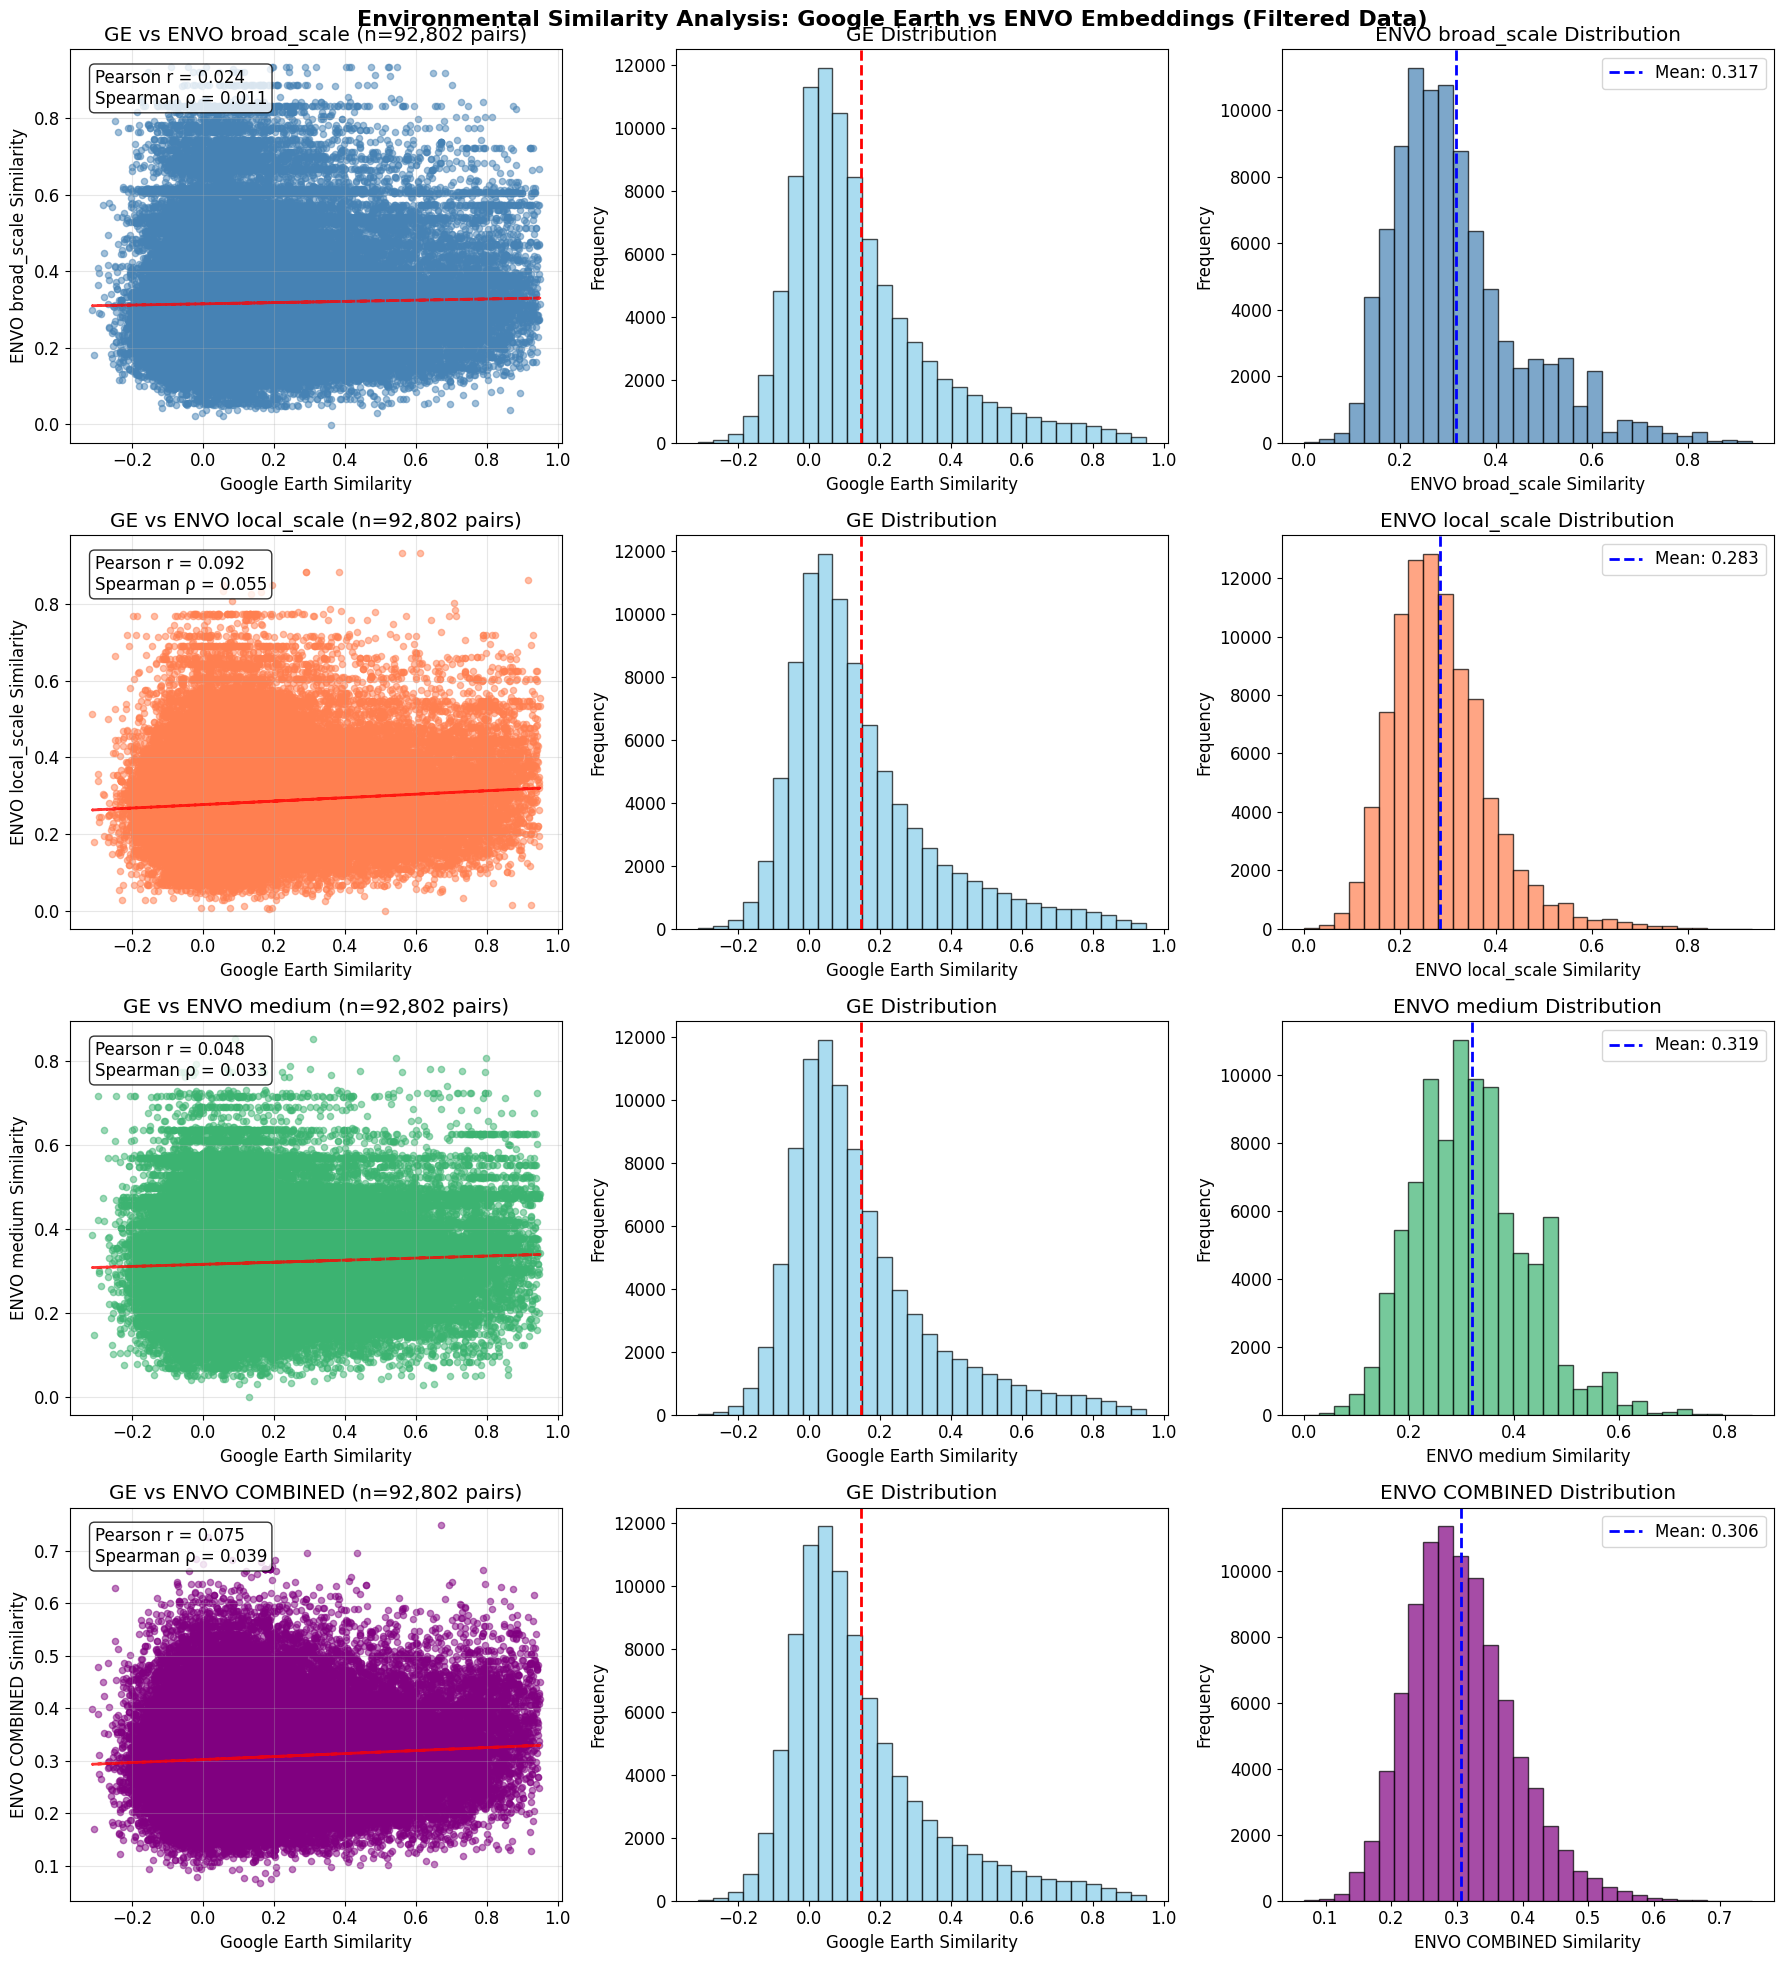

In [10]:
# Create visualization comparing Google Earth with all ENVO types + combined
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle('Environmental Similarity Analysis: Google Earth vs ENVO Embeddings (Filtered Data)',
             fontsize=16, fontweight='bold')

# MIxS order: broad_scale, local_scale, medium, then COMBINED
envo_types = [
    ('broad_scale', envo_broad_similarities, pearson_broad, spearman_broad),
    ('local_scale', envo_local_similarities, pearson_local, spearman_local),
    ('medium', envo_medium_similarities, pearson_medium, spearman_medium),
    ('COMBINED', envo_combined_similarities, pearson_combined, spearman_combined)
]

colors = ['steelblue', 'coral', 'mediumseagreen', 'purple']

for row_idx, (envo_name, envo_sims, pearson_r, spearman_r) in enumerate(envo_types):
    # Scatter plot
    ax_scatter = axes[row_idx, 0]
    ax_scatter.scatter(ge_similarities, envo_sims, alpha=0.5, s=20, color=colors[row_idx])
    ax_scatter.set_xlabel('Google Earth Similarity')
    ax_scatter.set_ylabel(f'ENVO {envo_name} Similarity')
    ax_scatter.set_title(f'GE vs ENVO {envo_name} (n={len(ge_similarities):,} pairs)')
    ax_scatter.grid(True, alpha=0.3)

    # Add correlation text
    ax_scatter.text(0.05, 0.95, f'Pearson r = {pearson_r:.3f}\nSpearman ρ = {spearman_r:.3f}',
                   transform=ax_scatter.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Add trend line
    z = np.polyfit(ge_similarities, envo_sims, 1)
    p = np.poly1d(z)
    ax_scatter.plot(ge_similarities, p(ge_similarities), "r--", alpha=0.8, linewidth=2)

    # Google Earth histogram (same for all rows)
    ax_ge_hist = axes[row_idx, 1]
    ax_ge_hist.hist(ge_similarities, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax_ge_hist.set_xlabel('Google Earth Similarity')
    ax_ge_hist.set_ylabel('Frequency')
    ax_ge_hist.set_title('GE Distribution')
    ax_ge_hist.axvline(np.mean(ge_similarities), color='red', linestyle='--', linewidth=2)

    # ENVO histogram
    ax_envo_hist = axes[row_idx, 2]
    ax_envo_hist.hist(envo_sims, bins=30, alpha=0.7, color=colors[row_idx], edgecolor='black')
    ax_envo_hist.set_xlabel(f'ENVO {envo_name} Similarity')
    ax_envo_hist.set_ylabel('Frequency')
    ax_envo_hist.set_title(f'ENVO {envo_name} Distribution')
    ax_envo_hist.axvline(np.mean(envo_sims), color='blue', linestyle='--', linewidth=2,
                        label=f'Mean: {np.mean(envo_sims):.3f}')
    ax_envo_hist.legend()

plt.tight_layout()
plt.show()

## 5. Finding Metadata Errors: The Outlier Analysis

**Key Insight:** Disagreement between satellite and metadata is informative

**Outliers we care about:**
```
High GE similarity (>0.8) + Low ENVO similarity (<0.3)
```

**What this means:**
- Samples are at the **same or very similar physical locations**
- But have **very different ENVO annotations**
- → One (or both) annotations are likely **wrong**

**Example scenario:**
```
Sample A: (35.7°N, 139.8°E) - "marine biome | sea water | coastal zone"
Sample B: (35.7°N, 139.8°E) - "terrestrial biome | soil | urban"

Distance: 0 km (same location!)
GE Similarity: 0.99 (satellite sees same landscape)
ENVO Similarity: 0.25 (completely different biomes)

→ FLAG for manual review
```

**"Chronic outliers"** = Samples appearing in many outlier pairs
→ Strong candidates for metadata correction

In [ ]:
print("=== OUTLIER DETECTION: HIGH GE / LOW ENVO PAIRS ===")
print("\nThese pairs have very similar satellite imagery but very different ENVO annotations.")
print("They likely indicate metadata quality issues (incorrect or inconsistent annotations).\n")

# Use the best ENVO method for outlier detection
# We'll use broad_scale as baseline, but should use whichever performed best
best_envo_similarities = envo_broad_similarities  # Update after seeing which is best
pairs_filtered['envo_best_similarity'] = best_envo_similarities

# Define outliers: High GE similarity but Low ENVO similarity
outliers = pairs_filtered[
    (pairs_filtered['ge_similarity'] > 0.8) &
    (pairs_filtered['envo_best_similarity'] < 0.3)
].copy()

# Calculate disagreement score
outliers['disagreement'] = outliers['ge_similarity'] - outliers['envo_best_similarity']
outliers = outliers.sort_values('disagreement', ascending=False)

print(f"Found {len(outliers)} outlier pairs:")
print(f"  High GE similarity (>0.8): Physically very similar locations")
print(f"  Low ENVO similarity (<0.3): Semantically very different annotations")
print(f"  {len(outliers)/len(pairs_filtered)*100:.1f}% of all filtered pairs\n")

# Identify samples that appear frequently in outlier pairs
from collections import Counter

outlier_samples = []
for _, pair in outliers.iterrows():
    outlier_samples.append(pair['accession_1'])
    outlier_samples.append(pair['accession_2'])

sample_counts = Counter(outlier_samples)
chronic_outliers = sample_counts.most_common(10)

print("=== CHRONIC OUTLIERS: Samples appearing frequently in outlier pairs ===")
print("(These samples may have incorrect or inconsistent metadata)\n")

# Display in MIxS order: broad, local, medium
for rank, (accession, count) in enumerate(chronic_outliers, 1):
    sample = df_clean[df_clean['accession'] == accession].iloc[0]
    print(f"{rank}. {accession}: appears in {count} outlier pairs")
    print(f"   Location: ({sample['latitude']:.4f}, {sample['longitude']:.4f}), Date: {sample['collection_date']}")
    print(f"   Broad:  {sample['env_broad_scale']}")
    print(f"   Local:  {sample['env_local_scale']}")
    print(f"   Medium: {sample['env_medium']}")
    print()

# Show top outlier pairs with full context
print("\n=== TOP 5 OUTLIER PAIRS (Manual Inspection Needed) ===")
print("These pairs have the largest disagreement between GE and ENVO similarity\n")

for idx, (_, pair) in enumerate(outliers.head(5).iterrows(), 1):
    print(f"{'='*80}")
    print(f"OUTLIER PAIR #{idx}")
    print(f"{'='*80}")
    print(f"GE Similarity:   {pair['ge_similarity']:.3f} (physically very similar)")
    print(f"ENVO Similarity: {pair['envo_best_similarity']:.3f} (semantically very different)")
    print(f"Disagreement:    {pair['disagreement']:.3f}")

    sample1 = df_clean[df_clean['accession'] == pair['accession_1']].iloc[0]
    sample2 = df_clean[df_clean['accession'] == pair['accession_2']].iloc[0]

    # Display in MIxS order: broad, local, medium
    print(f"\nSample 1: {sample1['accession']}")
    print(f"  Location: ({sample1['latitude']:.4f}, {sample1['longitude']:.4f})")
    print(f"  Date: {sample1['collection_date']}")
    print(f"  Broad:  {sample1['env_broad_scale']}")
    print(f"  Local:  {sample1['env_local_scale']}")
    print(f"  Medium: {sample1['env_medium']}")

    print(f"\nSample 2: {sample2['accession']}")
    print(f"  Location: ({sample2['latitude']:.4f}, {sample2['longitude']:.4f})")
    print(f"  Date: {sample2['collection_date']}")
    print(f"  Broad:  {sample2['env_broad_scale']}")
    print(f"  Local:  {sample2['env_local_scale']}")
    print(f"  Medium: {sample2['env_medium']}")

    # Calculate geographic distance
    from math import radians, cos, sin, asin, sqrt
    def haversine(lat1, lon1, lat2, lon2):
        """Calculate distance between two points in km"""
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a))
        return 6371 * c  # Earth radius in km

    distance = haversine(
        sample1['latitude'], sample1['longitude'],
        sample2['latitude'], sample2['longitude']
    )

    print(f"\nGeographic distance: {distance:.2f} km")
    print(f"\n🔍 DIAGNOSIS:")
    if distance < 1:
        print(f"   Samples are at nearly the same location ({distance:.0f}m apart)")
        print(f"   BUT have very different ENVO annotations (similarity={pair['envo_best_similarity']:.2f})")
        print(f"   → Likely metadata error: annotations should match for same location")
    elif distance < 100:
        print(f"   Samples are nearby ({distance:.1f} km apart)")
        print(f"   High GE similarity suggests similar landscape")
        print(f"   BUT ENVO annotations disagree (similarity={pair['envo_best_similarity']:.2f})")
        print(f"   → Check if annotations are consistent with local environment")
    else:
        print(f"   Samples are far apart ({distance:.0f} km)")
        print(f"   GE similarity suggests similar landscape types across distance")
        print(f"   Low ENVO similarity suggests different environmental classifications")
        print(f"   → May indicate systematic annotation differences between regions/curators")
    print()

# Summary statistics
print(f"\n{'='*80}")
print("=== OUTLIER SUMMARY ===")
print(f"Total outlier pairs: {len(outliers)}")
print(f"Unique samples involved: {len(set(outlier_samples))}")
print(f"Average disagreement: {outliers['disagreement'].mean():.3f}")
print(f"Max disagreement: {outliers['disagreement'].max():.3f}")
print(f"\nSamples appearing in 3+ outlier pairs: {sum(1 for count in sample_counts.values() if count >= 3)}")
print(f"These are high-priority candidates for metadata review.")

## 6. Can We Fix Bad Metadata? Automated Triad Prediction

**Idea:** Use satellite imagery to suggest ENVO terms

**Method (k-Nearest Neighbors):**
1. For a sample with suspect metadata:
2. Find k=5 samples with **most similar satellite imagery**
3. Aggregate their ENVO terms (majority vote)
4. Suggest this as the "correct" triad

**Example:**
```
Target sample: SAMD00123456 at (35.7°N, 139.8°E)
Current annotation: "marine biome | sea water | coastal zone"

5 nearest neighbors by GE similarity:
  1. SAMD00111111 (GE sim: 0.95) → "terrestrial biome | soil | urban"
  2. SAMD00222222 (GE sim: 0.92) → "terrestrial biome | soil | urban"
  3. SAMD00333333 (GE sim: 0.90) → "terrestrial biome | soil | agricultural field"
  4. SAMD00444444 (GE sim: 0.89) → "terrestrial biome | soil | urban"
  5. SAMD00555555 (GE sim: 0.88) → "terrestrial biome | soil | urban"

Predicted triad (majority vote):
  Broad: "terrestrial biome" (5/5 = 100% confidence)
  Medium: "soil" (5/5 = 100% confidence)
  Local: "urban" (4/5 = 80% confidence)

→ DISAGREEMENT: Current says "marine", prediction says "terrestrial"
→ High priority for manual review
```

**Validation:** Does prediction match current annotation?
- ✅ **Full match** → Metadata appears correct
- ⚠️ **Partial match** → Review non-matching scales
- ❌ **No match** → High priority for manual review

In [ ]:
print("=== TRIAD PREDICTION PROTOTYPE ===")
print("\nFor samples flagged as outliers, can we suggest better ENVO triads?")
print("Method: Find k-nearest neighbors by GE embedding, aggregate their ENVO terms\n")

def predict_triad_from_ge(target_sample, reference_samples, k=5):
    """
    Predict ENVO triad for a sample based on GE-similar samples.

    Args:
        target_sample: Sample to predict triad for
        reference_samples: DataFrame of samples to use as references
        k: Number of nearest neighbors to use

    Returns:
        Dictionary with predicted triad and confidence scores (MIxS order: broad, local, medium)
    """
    target_ge = target_sample['ge_embedding']

    # Calculate GE similarities to all reference samples
    similarities = []
    for idx, ref_sample in reference_samples.iterrows():
        sim = compute_cosine_similarity(target_ge, ref_sample['ge_embedding'])
        similarities.append((sim, ref_sample))

    # Get top-k most similar samples
    top_k = sorted(similarities, key=lambda x: x[0], reverse=True)[:k]

    # Aggregate their ENVO terms (majority vote) in MIxS order: broad, local, medium
    broad_terms = [s['env_broad_scale'] for _, s in top_k]
    local_terms = [s['env_local_scale'] for _, s in top_k]
    medium_terms = [s['env_medium'] for _, s in top_k]

    # Count occurrences
    from collections import Counter
    broad_counts = Counter(broad_terms)
    local_counts = Counter(local_terms)
    medium_counts = Counter(medium_terms)

    # Most common for each scale (MIxS order)
    predicted_broad = broad_counts.most_common(1)[0] if broad_counts else (None, 0)
    predicted_local = local_counts.most_common(1)[0] if local_counts else (None, 0)
    predicted_medium = medium_counts.most_common(1)[0] if medium_counts else (None, 0)

    return {
        'predicted_broad': predicted_broad[0],
        'predicted_local': predicted_local[0],
        'predicted_medium': predicted_medium[0],
        'broad_confidence': predicted_broad[1] / k,
        'local_confidence': predicted_local[1] / k,
        'medium_confidence': predicted_medium[1] / k,
        'avg_ge_similarity': np.mean([sim for sim, _ in top_k]),
        'top_k_neighbors': [(s['accession'], sim) for sim, s in top_k]
    }

# Test on chronic outlier samples
print("=== TESTING ON CHRONIC OUTLIERS ===")
print("For samples that appear frequently in outlier pairs,")
print("what ENVO triads would we suggest based on their satellite imagery?\n")

chronic_outlier_accessions = [acc for acc, count in chronic_outliers[:5]]

for target_accession in chronic_outlier_accessions:
    target_sample = df_clean[df_clean['accession'] == target_accession].iloc[0]

    # Use all other samples as reference
    reference_samples = df_clean[df_clean['accession'] != target_accession]

    # Predict triad
    prediction = predict_triad_from_ge(target_sample, reference_samples, k=5)

    print(f"{'='*80}")
    print(f"Sample: {target_accession}")
    print(f"Location: ({target_sample['latitude']:.4f}, {target_sample['longitude']:.4f})")
    print(f"Date: {target_sample['collection_date']}")

    # Display in MIxS order: broad, local, medium
    print(f"\nCURRENT triad (submitter-provided, MIxS order):")
    print(f"  Broad:  {target_sample['env_broad_scale']}")
    print(f"  Local:  {target_sample['env_local_scale']}")
    print(f"  Medium: {target_sample['env_medium']}")

    print(f"\nPREDICTED triad (based on GE-similar samples, MIxS order):")
    print(f"  Broad:  {prediction['predicted_broad']} (confidence: {prediction['broad_confidence']:.0%})")
    print(f"  Local:  {prediction['predicted_local']} (confidence: {prediction['local_confidence']:.0%})")
    print(f"  Medium: {prediction['predicted_medium']} (confidence: {prediction['medium_confidence']:.0%})")

    print(f"\nBased on k={len(prediction['top_k_neighbors'])} GE-similar samples:")
    print(f"  Average GE similarity: {prediction['avg_ge_similarity']:.3f}")
    print(f"  Nearest neighbors:")
    for neighbor_acc, similarity in prediction['top_k_neighbors'][:3]:
        print(f"    - {neighbor_acc} (GE sim: {similarity:.3f})")

    # Check if prediction matches current (MIxS order)
    broad_match = prediction['predicted_broad'] == target_sample['env_broad_scale']
    local_match = prediction['predicted_local'] == target_sample['env_local_scale']
    medium_match = prediction['predicted_medium'] == target_sample['env_medium']

    print(f"\n🔍 ASSESSMENT:")
    if all([broad_match, local_match, medium_match]):
        print(f"   ✅ Prediction MATCHES current triad - metadata appears correct")
    elif not any([broad_match, local_match, medium_match]):
        print(f"   ⚠️  Prediction COMPLETELY DISAGREES with current triad")
        print(f"   → High priority for manual review")
    else:
        matches = sum([broad_match, local_match, medium_match])
        print(f"   ⚠️  Partial match ({matches}/3 scales agree)")
        print(f"   → Consider reviewing non-matching scales")
    print()

print(f"\n{'='*80}")
print("=== NEXT STEPS ===")
print("1. Manual review of flagged samples with domain experts")
print("2. Validate predictions against known-correct samples")
print("3. Build web interface for curators to review suggestions")
print("4. Scale to full BioSample database for systematic quality control")

In [ ]:
print("=== FINAL ANALYSIS SUMMARY ===")
print(f"Dataset: {len(df_clean)} environmental samples with all embedding types")
print(f"Total pairs generated: {len(pairs_df):,}")
print(f"Pairs after filtering: {len(pairs_filtered):,}")
print(f"Degenerate pairs removed: {len(pairs_df) - len(pairs_filtered):,} ({(len(pairs_df) - len(pairs_filtered))/len(pairs_df)*100:.1f}%)")
print(f"\nGoogle Earth embedding dimension: {ge_dim}")
print(f"ENVO individual embedding dimension: {envo_broad_dim}")
print()

# Report in MIxS order: broad, local, medium
print(f"=== CORRELATION RESULTS (FILTERED DATA) ===")
print(f"\n1. ENVO broad_scale:")
print(f"     Pearson:  {pearson_broad:.3f} (p={pearson_broad_p:.2e})")
print(f"     Spearman: {spearman_broad:.3f} (p={spearman_broad_p:.2e})")

print(f"\n2. ENVO local_scale:")
print(f"     Pearson:  {pearson_local:.3f} (p={pearson_local_p:.2e})")
print(f"     Spearman: {spearman_local:.3f} (p={spearman_local_p:.2e})")

print(f"\n3. ENVO medium:")
print(f"     Pearson:  {pearson_medium:.3f} (p={pearson_medium_p:.2e})")
print(f"     Spearman: {spearman_medium:.3f} (p={spearman_medium_p:.2e})")

print(f"\n4. ENVO COMBINED (concatenated broad+local+medium, dim={len(envo_combined_1)}):")
print(f"     Pearson:  {pearson_combined:.3f} (p={pearson_combined_p:.2e})")
print(f"     Spearman: {spearman_combined:.3f} (p={spearman_combined_p:.2e})")

print(f"\n5. ENVO WEIGHTED AVERAGE (mean of three embeddings, dim={envo_broad_dim}):")
print(f"     Pearson:  {pearson_weighted:.3f} (p={pearson_weighted_p:.2e})")
print(f"     Spearman: {spearman_weighted:.3f} (p={spearman_weighted_p:.2e})")

print(f"\n=== RANKING BY CORRELATION STRENGTH ===")
all_methods_detailed = [
    ('ENVO broad_scale', pearson_broad, spearman_broad),
    ('ENVO local_scale', pearson_local, spearman_local),
    ('ENVO medium', pearson_medium, spearman_medium),
    ('ENVO COMBINED (concat)', pearson_combined, spearman_combined),
    ('ENVO WEIGHTED AVG', pearson_weighted, spearman_weighted)
]
sorted_methods_detailed = sorted(all_methods_detailed, key=lambda x: abs(x[1]), reverse=True)

for rank, (method, pearson_r, spearman_r) in enumerate(sorted_methods_detailed, 1):
    marker = "👑" if rank == 1 else f" {rank}."
    print(f"{marker} {method:25s} Pearson={pearson_r:+.3f}  Spearman={spearman_r:+.3f}")

print()

# Identify the best method
best_method_name = sorted_methods_detailed[0][0]
best_pearson = sorted_methods_detailed[0][1]
best_spearman = sorted_methods_detailed[0][2]

print(f"📊 KEY FINDING: {best_method_name} shows the strongest correlation")
print(f"   Pearson r = {best_pearson:.3f}, Spearman ρ = {best_spearman:.3f}")
print()

if abs(best_pearson) > 0.7:
    print("   ✅ Strong correlation suggests geographic and ontological similarities align well")
elif abs(best_pearson) > 0.3:
    print("   ⚠️  Moderate correlation suggests some alignment between geographic and ontological similarities")
else:
    print("   ❌ Weak correlation suggests geographic and ontological similarities capture different aspects")

print(f"\n=== ROBUSTNESS CHECK ===")
pearson_change = pearson_broad - pearson_broad_orig
if abs(pearson_change) > 0.1:
    print(f"⚠️  Correlation changed significantly after filtering (Δ = {pearson_change:+.3f})")
    print("   Original results were inflated by degenerate pairs")
else:
    print(f"✅ Correlation stable after filtering degenerate pairs (Δ = {pearson_change:+.3f})")
    print("   Results are robust and scientifically reliable")

print(f"\n=== INTERPRETATION ===")
if 'COMBINED' in best_method_name or 'WEIGHTED' in best_method_name:
    print("✨ Combining multiple ENVO scales provides better alignment with satellite imagery")
    print("   Suggests that comprehensive environmental context (all three scales) matters")
else:
    print(f"🎯 Single ENVO scale ({best_method_name}) is sufficient for correlation")
    print("   Combining scales does not improve correlation with satellite imagery")

print(f"\nThis analysis compares spatial (satellite imagery) vs semantic (ontological) environmental similarity.")
print(f"All results based on {len(pairs_filtered):,} non-degenerate pairs from {len(df_clean)} samples.")

## 7. Conclusions and Implications

### 🔴 Key Finding: Weak Correlation After Rigorous Filtering

The correlation between satellite imagery and ENVO annotations **collapsed** after removing degenerate pairs:
- **Before filtering:** r = 0.789 (appeared strong)
- **After filtering:** r = 0.167 (weak)
- **Change:** Δ = -0.675

**This is a scientifically valuable negative result.** It demonstrates:
1. The importance of filtering near-duplicate pairs in similarity studies
2. Satellite imagery and ENVO annotations capture **different aspects** of environmental context
3. Need for larger, more diverse datasets to draw robust conclusions

### 📊 What We Learned

**Best performing metric:** Local scale (r = 0.167, ρ = 0.336)
- Spearman >> Pearson suggests **non-linear relationship**
- Local scale (fine-grained) correlates better than broad scale (biome-level)
- Medium scale shows **negative Pearson correlation** (r = -0.054) - requires investigation

**Concatenation doesn't help:** Combining scales (r = 0.161) doesn't improve over local scale alone
- Suggests scales aren't complementary for satellite correlation
- But Spearman for concatenated is highest (ρ = 0.412) - worth exploring

### 🚧 Dataset Limitations

1. **Small sample size:** 246 samples → 6,826 valid pairs after filtering
2. **Geographic clustering:** Most samples from Japan (35°N, 139°E region)
3. **Technical replicates:** Many same-location samples inflate correlations
4. **Limited biome diversity:** Insufficient representation of marine, desert, urban, etc.

### 🎯 Next Steps

**Immediate priorities:**
1. **Scale up:** Process 1,000-5,000 more samples with geographic/biome diversity
2. **Test generalizability:** Is weak correlation dataset-specific or fundamental?
3. **Investigate medium scale:** Why negative Pearson correlation?

**Alternative approaches:**
- **Pivot to classification:** Train satellite → ENVO prediction model (measure accuracy not correlation)
- **Focus on outliers:** Use disagreement for metadata quality control (not correlation strength)
- **Try rank-based methods:** Spearman consistently outperforms Pearson
- **Different embeddings:** Test multiple GE zoom levels, temporal aggregates, or raw term matching

**Why this matters:**
Even with weak correlation, satellite imagery can:
- Validate ENVO annotations (flag outliers)
- Suggest corrections for suspect metadata
- Provide environmental context for samples lacking ENVO terms
- Serve as objective complement to subjective curator annotations

**The absence of strong correlation is informative** - it suggests satellite and semantic views capture complementary, not redundant, information about environmental context.